# (let the bot generate this desc)

Imports:

In [ ]:
try:
    import sys
    import requests
    from zipfile import ZipFile
    from tqdm import tqdm
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from gensim.test.utils import datapath, get_tmpfile
    from gensim.models import KeyedVectors
    from gensim.scripts.glove2word2vec import glove2word2vec
    import os

except ImportError:
    sys.exit("""You are missing necessary Python libraries!
    Run the installation chunck.""")

import warnings; warnings.simplefilter('ignore')

plt.style.use('ggplot')

**Installation chunk** (uncomment necessary commands)

In [ ]:
# %pip install numpy
# %pip install matplotlib
# %pip install sklearn
# %pip install gensim
# %pip install requests
# %pip install zipfile

**Load the necessary files** (it'll download if necessary)

(for future commits: see if line `word_vectors = api.load("glove-wiki-gigaword-100")` from [here](https://radimrehurek.com/gensim/models/keyedvectors.html) does a better job for both this NB and maybe a Colab NB as well)

In [2]:
# This function downloads a file from "url" and presents a progress bar:
def download_file(url, glove_file):
    r = requests.get(url, stream=True, allow_redirects=True)
    total_size = int(r.headers.get('content-length'))
    initial_pos = 0
    with open(glove_file,'wb') as f: 
        with tqdm(total=total_size,
                  unit='B',
                  unit_scale=True,                      
                  desc=glove_file,initial=initial_pos, ascii=True) as pbar:
          for ch in r.iter_content(chunk_size=1024):                             
                  if ch:
                      f.write(ch) 
                      pbar.update(len(ch))

# Setting up paths:
folder_for_glove = os.getcwd() + os.sep + 'glove' + os.sep
glove_file = datapath(folder_for_glove + 'glove.6B.100d.txt')
url_for_zip = "https://nlp.stanford.edu/data/glove.6B.zip"
zip_file = datapath(folder_for_glove + url_for_zip.split('/')[-1])

# Check whether glove file exists in the envorironment, if not, download it:
does_glove_file_exist = os.path.exists(glove_file)
if does_glove_file_exist == False:
    # This means we'll need to download the zipped files and unzip them to the necessary folder:
    # Check folder exists:
    does_glove_folder_exist = os.path.exists(folder_for_glove)
    if does_glove_folder_exist == False:
        # Create a folder for glove:
        os.mkdir(folder_for_glove)
                 
    # Download zipped files:
    print("Downloading the zip file from:   " + url_for_zip)
    zip_file0 = download_file(url_for_zip, zip_file)

    # Extract files:
    with ZipFile(zip_file, 'r') as zipObj:
        print("Extracting glove files from the zipped file.")
        zipObj.extractall(folder_for_glove)
        print("Done extracting.")
else:
    print("Successfully located necessary glove file.")
        

Successfully located necessary glove file.


**Load necessary word embeddings**

In [3]:
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

(400000, 100)

### Similarity search with GLOVE word embedding

In [ ]:
# Load pre-trained embeddings (make sure you have a compatible file)
model = KeyedVectors.load_word2vec_format(word2vec_glove_file, binary=False)

def analogy(positive, negative=None, topn=5):
    negative = negative or []
    result = model.most_similar(positive=positive, negative=negative, topn=topn)
    for word, score in result:
        print(f"{word:15s} (score: {score:.4f})")

# Example usage:
print("Analogy with ['c++'] as positive:")
analogy(positive=['c++'])
print("\nAnalogy with 'linkedin':")
analogy(positive=['linkedin'])


Analogy with ['c++'] as positive:
compiler        (score: 0.7527)
fortran         (score: 0.7298)
compilers       (score: 0.7107)
javascript      (score: 0.6958)
objective-c     (score: 0.6713)

Analogy with 'linkedin':
friendster      (score: 0.7622)
myspace         (score: 0.7512)
myspace.com     (score: 0.7366)
facebook        (score: 0.7189)
pinterest       (score: 0.7188)


### Visualize GLOVE embedding in 2 dimensions using PCA for dimensionality reduction

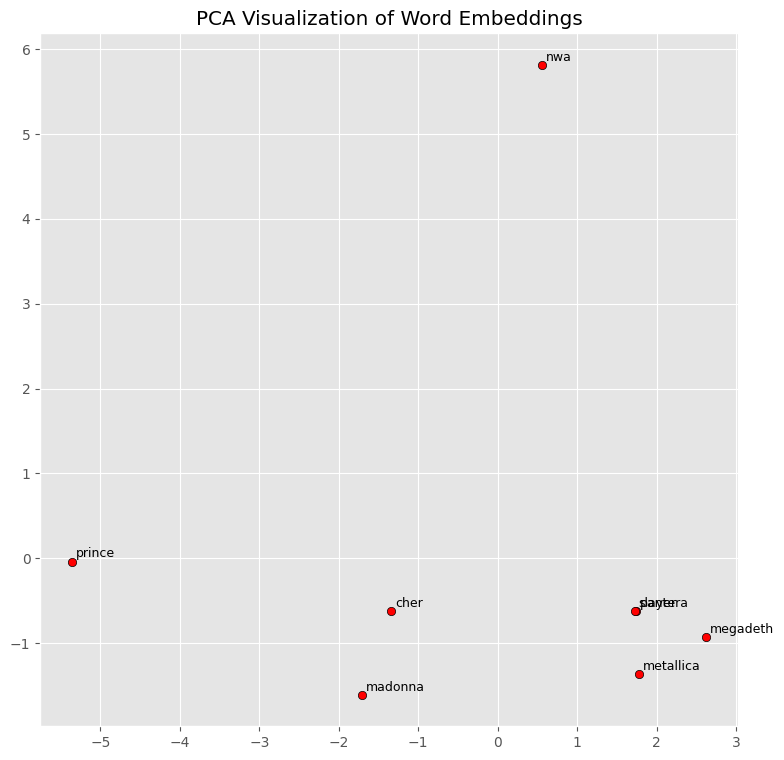

In [22]:
def display_pca_scatterplot(model, words=None, sample=0):
    # Get words: either provided, sampled, or all from the vocabulary.
    if words is None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = list(model.vocab.keys())
            
    vectors = np.array([model[w] for w in words])
    twodim = PCA(n_components=2).fit_transform(vectors)
    
    plt.figure(figsize=(9,9))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word, fontsize=9)
    plt.title("PCA Visualization of Word Embeddings")
    plt.show()

# Example call:
display_pca_scatterplot(model, 
                        words=['metallica', 'megadeth', 'pantera', 'slayer',
                               'madonna', 'cher', 'nwa', 'prince'])


### Visualize GLOVE embedding in 2 dimensions using tSNE for dimensionality reduction

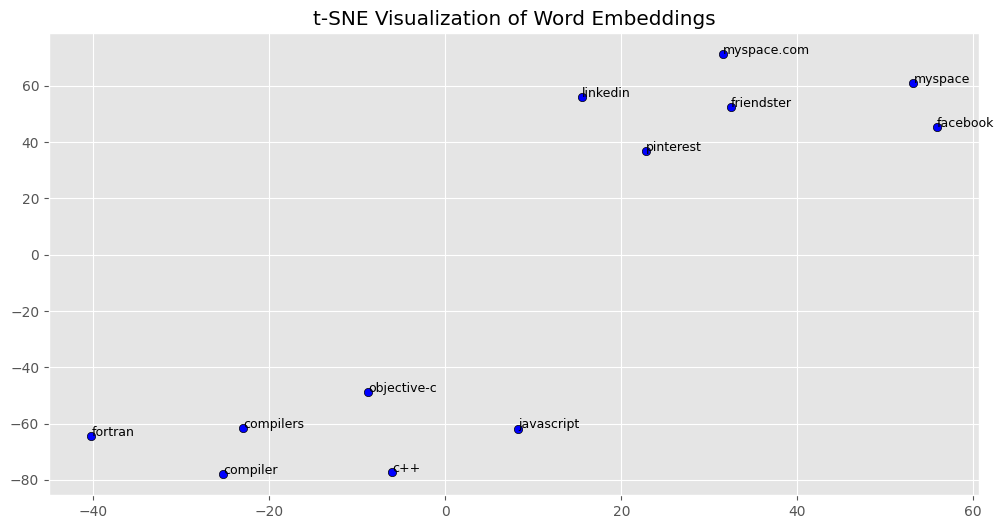

In [24]:

def display_tsne_scatterplot(model, words=None, sample=0):
    if words is None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = list(model.vocab.keys())
            
    vectors = np.array([model[w] for w in words])
    tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)
    twodim = tsne.fit_transform(vectors)
    
    plt.figure(figsize=(12,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='b')
    for word, (x, y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word, fontsize=9)
    plt.title("t-SNE Visualization of Word Embeddings")
    plt.show()

# Example call:
display_tsne_scatterplot(model, words=['c++',
'compiler',
'fortran',
'compilers',
'javascript',
'objective-c',
'linkedin',
'friendster',
'myspace',
'myspace.com',
'facebook',
'pinterest'])


